In [1]:
import pandas as pd
import numpy as np
from utils import *
import pytensor.tensor as pt  # Import PyTensor (Theano backend)

In [2]:
df, scaling_factors = read_dd_data('../data/PD_data',standardize=True)
df

,rcert,runcert,event_prob,choice,condition,rt,odds,participant,participant_idx
0,0.200650,0.016191,0.10,0.0,1.0,-1.742665,9.000000,bh348lli7,0
1,0.404075,0.019051,0.90,0.0,1.0,-1.743614,0.111111,bh348lli7,0
2,0.037910,0.001269,0.50,0.0,1.0,-1.743748,1.000000,bh348lli7,0
3,0.037910,0.054384,0.25,0.0,1.0,-1.743792,3.000000,bh348lli7,0
4,0.810926,0.141427,0.50,0.0,1.0,-1.743582,1.000000,bh348lli7,0
...,...,...,...,...,...,...,...,...,...
9795,-0.409626,-0.178325,0.10,0.0,2.0,-1.742868,9.000000,u3yyfob1i,48
9796,-0.409626,-0.071741,0.25,1.0,2.0,-1.742721,3.000000,u3yyfob1i,48
9797,-0.206201,-0.017561,0.10,1.0,2.0,-1.742701,9.000000,u3yyfob1i,48
9798,-2.037028,-0.178325,0.75,0.0,2.0,-1.742424,0.333333,u3yyfob1i,48


In [3]:
df.describe()

,rcert,runcert,event_prob,choice,condition,rt,odds,participant_idx
count,9.749000e+03,9.749000e+03,9749.000000,9749.000000,9749.000000,9749.000000,9749.000000,9749.000000
mean,-1.494115e-17,-5.284065e-18,0.500164,0.393887,1.498513,-1.742624,2.690339,24.001026
std,1.000000e+00,1.000000e+00,0.298548,0.488635,0.500023,0.000418,3.318231,14.143768
min,-2.037028e+00,-8.083318e+00,0.100000,0.000000,1.000000,-1.744270,0.111111,0.000000
25%,-4.096258e-01,-5.042424e-02,0.250000,0.000000,1.000000,-1.742849,0.333333,12.000000
50%,3.790984e-02,1.109205e-03,0.500000,0.000000,1.000000,-1.742608,1.000000,24.000000
75%,4.040754e-01,5.438353e-02,0.750000,1.000000,2.000000,-1.742356,3.000000,36.000000
max,2.031478e+00,8.081948e+00,0.900000,1.000000,2.000000,-1.741555,9.000000,48.000000


Number of participants: 49
Average trials per participant: 198.96
Min trials: 192
Max trials: 200


<Axes: >

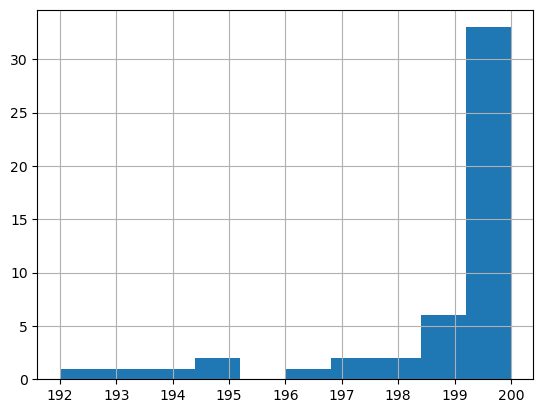

In [4]:
# print number of participants
print(f"Number of participants: {df['participant'].nunique()}")

# Calculate trials per participant
trials_per_participant = df.groupby('participant').size()
print(f"Average trials per participant: {trials_per_participant.mean():.2f}")
print(f"Min trials: {trials_per_participant.min()}")
print(f"Max trials: {trials_per_participant.max()}")

trials_per_participant.hist()

In [5]:
def create_model_parameters(n_participants, config="default"):
    """
    Create group and participant-level parameters for the probabilistic discounting model.
    
    Args:
        n_participants (int): Number of participants in the study
        config (str): Configuration name for different parameter setups
        
    Returns:
        dict: Dictionary containing all model parameters
    """
    with pm.Model() as temp_model:

        # Initialize all parameters as None
        mu_k_raw = None
        mu_k = None
        sigma_k_raw = None 
        sigma_k = None
        mu_beta = None
        sigma_beta = None
        mu_beta0 = None
        sigma_beta0 = None
        mu_beta1 = None
        sigma_beta1 = None
        mu_sigma_RT = None
        sigma_sigma_RT = None
        k_raw = None
        k = None
        beta = None
        beta0 = None
        beta1 = None
        sigma_RT = None
        mu_lambda = None
        sigma_lambda = None
        lambda_raw = None
        loss_aversion = None

        if config == "default":
            # Group-level priors
            mu_k_raw = pm.Normal("mu_k_raw", mu=0, sigma=1)  # Reduced sigma back to 1
            mu_k = pm.Deterministic("mu_k", pm.math.exp(mu_k_raw))

            sigma_k_raw = pm.HalfNormal("sigma_k_raw", sigma=1)  # Reduced sigma back to 1
            sigma_k = pm.Deterministic("sigma_k", pm.math.exp(sigma_k_raw))

            mu_beta = pm.Normal("mu_beta", mu=0, sigma=1)  # Changed to Normal
            sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.5)  # Reduced sigma

            mu_beta0 = pm.Normal("mu_beta0", mu=0, sigma=1)
            sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=0.5)  # Reduced sigma

            mu_beta1 = pm.Normal("mu_beta1", mu=0, sigma=1)  # Changed to Normal
            sigma_beta1 = pm.HalfNormal("sigma_beta1", sigma=0.5)  # Reduced sigma

            mu_sigma_RT = pm.HalfNormal("mu_sigma_RT", sigma=0.5)  # Reduced sigma
            sigma_sigma_RT = pm.HalfNormal("sigma_sigma_RT", sigma=0.5)  # Reduced sigma

            # Add loss aversion parameter (lambda)
            mu_lambda = pm.Normal("mu_lambda", mu=1, sigma=0.5)  # Group-level loss aversion
            sigma_lambda = pm.HalfNormal("sigma_lambda", sigma=0.5)
            lambda_raw = pm.Normal("lambda_raw", mu=0, sigma=1, shape=n_participants)

            # Participant-level parameters
            k_raw = pm.Normal("k_raw", mu=0, sigma=1, shape=n_participants)
            k = pm.Deterministic("k", pm.math.exp(mu_k + sigma_k * k_raw))  # Removed scaling factor

            beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_participants)  # Changed to Normal
            beta0 = pm.Normal("beta0", mu=mu_beta0, sigma=sigma_beta0, shape=n_participants)
            beta1 = pm.Normal("beta1", mu=mu_beta1, sigma=sigma_beta1, shape=n_participants)  # Changed to Normal
            sigma_RT = pm.HalfNormal("sigma_RT", sigma=1, shape=n_participants) 
            loss_aversion = pm.Deterministic("loss_aversion", pm.math.exp(mu_lambda + sigma_lambda * lambda_raw))

            
        elif config == "simplified":
            # A simpler version with fewer hierarchical parameters
            # Add your simplified configuration here
            raise NotImplementedError("Simplified config not yet implemented")
        
        else:
            raise ValueError(f"Unknown configuration: {config}")
        
        # Get all parameters from the model
        params = {
            'group_level': {
                'mu_k': mu_k,
                'sigma_k': sigma_k,
                'mu_beta': mu_beta,
                'sigma_beta': sigma_beta,
                'mu_beta0': mu_beta0,
                'sigma_beta0': sigma_beta0,
                'mu_beta1': mu_beta1,
                'sigma_beta1': sigma_beta1,
                'mu_sigma_RT': mu_sigma_RT,
                'sigma_sigma_RT': sigma_sigma_RT,
                'mu_lambda': mu_lambda,
                'sigma_lambda': sigma_lambda
            },
            'participant_level': {
                'k': k,
                'beta': beta,
                'beta0': beta0,
                'beta1': beta1,
                'sigma_RT': sigma_RT,
                'loss_aversion': loss_aversion
            }
        }
        
    return params

In [6]:
def create_choice_discounting_model(df, config="default", params=None):
    """
    Create a probabilistic discounting model for the given dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the data

    Returns:
        dict: A dictionary containing the model parameters
    """

    choice = None

    # Extract observed data
    rcert = df["rcert"].values
    runcert = df["runcert"].values
    participant_ids = df["participant_idx"].values  # Integer IDs
    event_prob = df["event_prob"].values
    choice_data = df["choice"].astype(int).values  # Ensure it's an integer for Bernoulli

    if config == "loss-aversion":

        k = params['participant_level']['k']
        loss_aversion = params['participant_level']['loss_aversion']
        beta = params['participant_level']['beta']

        # For gains (condition 1)
        gains_mask = df['condition'] == 1

        SV_certain = pm.math.switch(gains_mask, 
                                rcert,  # gains
                                -loss_aversion[participant_ids] * rcert)  # losses
        
        SV_uncertain = pm.math.switch(gains_mask,
                                    runcert / (1 + k[participant_ids] * event_prob),  # gains
                                    -loss_aversion[participant_ids] * runcert / (1 + k[participant_ids] * event_prob))  # losses

        # Choice model (Bernoulli with logistic function)
        max_exp = 10
        exp = beta[participant_ids] * (SV_uncertain - SV_certain) # TODO: check order of SV_uncertain and SV_certain
        exp = pm.math.clip(exp, -max_exp, max_exp)

        prob_choose_uncertain = pm.Deterministic("prob_choose_uncertain",
            pm.math.sigmoid(exp) 
        )
        choice = pm.Bernoulli("choice", p=prob_choose_uncertain, observed=choice_data)

    elif config == "default":
        
        k = params['participant_level']['k']
        beta = params['participant_level']['beta']

        # Compute subjective values using hyperbolic discounting
        SV_certain = rcert
        SV_uncertain = runcert / (1 + k[participant_ids] * event_prob)

        # Choice model (Bernoulli with logistic function)
        max_exp = 10
        exp = beta[participant_ids] * (SV_uncertain - SV_certain) # TODO: check order of SV_uncertain and SV_certain
        exp = pm.math.clip(exp, -max_exp, max_exp)

        prob_choose_uncertain = pm.Deterministic("prob_choose_uncertain",
            pm.math.sigmoid(exp) 
        )
        choice = pm.Bernoulli("choice", p=prob_choose_uncertain, observed=choice_data)
    
    else:
        raise ValueError(f"Unknown configuration: {config}")
    
    return choice, SV_certain, SV_uncertain

In [7]:
def create_rt_model(df, config="default", params=None, decision_difficulty=None):
    """
    Create a reaction time model for the given dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the data

    """
    mu_RT = None
    rt_data = df["rt"].values

    # Extract observed data
    participant_ids = df["participant_idx"].values  # Integer IDs

    beta0 = params['participant_level']['beta0']
    beta1 = params['participant_level']['beta1']
    sigma_RT = params['participant_level']['sigma_RT']

    if config == "default":
        # Reaction time model (log-normal)
        mu_RT = pm.Deterministic("mu_RT", beta0[participant_ids] + beta1[participant_ids] * decision_difficulty)
    
        # NOTE: remember we are using log RTs not the actual RTs
        log_RT = pm.Normal("log_RT", mu=mu_RT, sigma=sigma_RT[participant_ids], observed=rt_data)

    return log_RT
        

In [8]:
participants = df["participant"].unique()
n_participants = len(participants)

with pm.Model() as model:
    # Create parameters
    params = create_model_parameters(n_participants, config="default")
    
    # Create choice model
    choice, SV_certain, SV_uncertain = create_choice_discounting_model(
        df, 
        config="loss-aversion", 
        params=params
    )
    
    # Create RT model using the SVs from choice model
    decision_difficulty = (SV_uncertain - SV_certain) ** 2
    log_RT = create_rt_model(
        df, 
        params=params, 
        decision_difficulty=decision_difficulty
    )
    
    # Sample
    model.debug(verbose=True)
    trace = pm.sample(2000, tune=1000,
                        target_accept=0.90,
                        return_inferencedata=True,
                        init='jitter+adapt_diag',
                        cores=4,
                        chains=4,
                        mp_ctx='spawn')
    

point={'mu_k_raw': array(0.), 'sigma_k_raw_log__': array(0.), 'mu_beta': array(0.), 'sigma_beta_log__': array(-0.69314718), 'mu_beta0': array(0.), 'sigma_beta0_log__': array(-0.69314718), 'mu_beta1': array(0.), 'sigma_beta1_log__': array(-0.69314718), 'mu_sigma_RT_log__': array(-0.69314718), 'sigma_sigma_RT_log__': array(-0.69314718), 'k_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_k_raw, sigma_k_raw, mu_beta, sigma_beta, mu_beta0, sigma_beta0, mu_beta1, sigma_beta1, mu_sigma_RT, sigma_sigma_RT, k_raw, beta, beta0, beta1, sigma_RT, mu_lambda, sigma_lambda, lambda_raw]


Output()

KeyError: 0

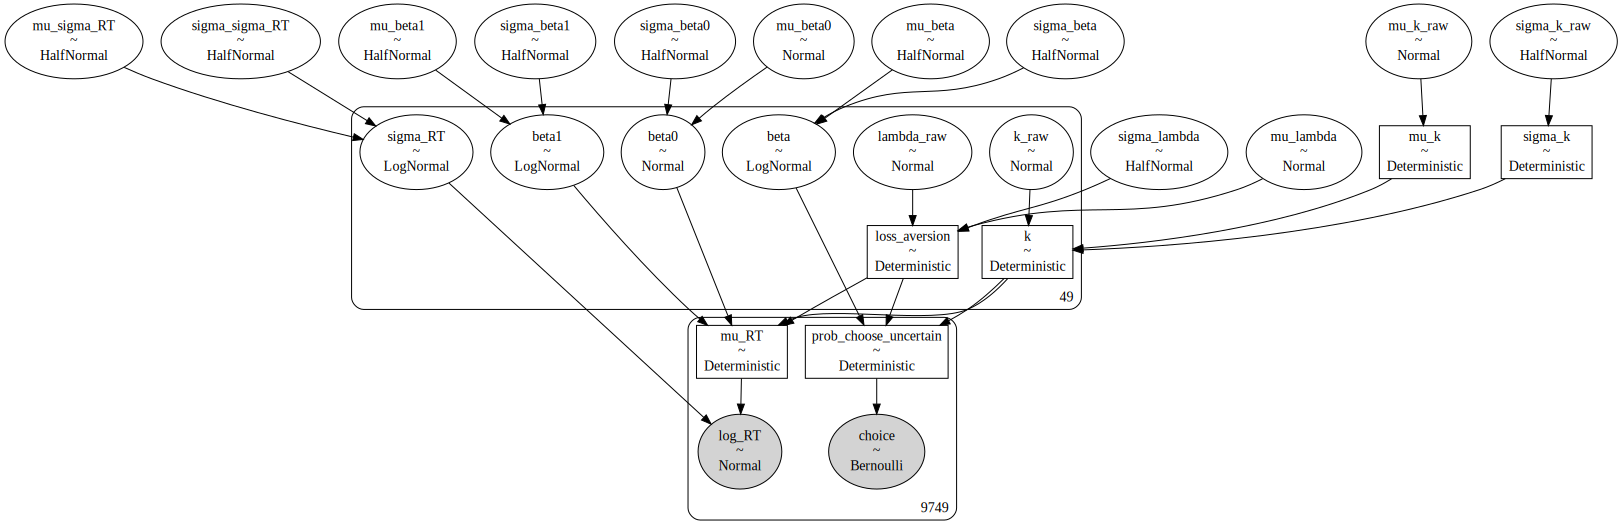

In [10]:
pm.model_to_graphviz(model)


In [11]:
import arviz as az
import matplotlib.pyplot as plt

# Trace plot: Check parameter convergence across chains
az.plot_trace(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])

plt.show()

# Posterior distributions: Check inferred parameter values
az.plot_posterior(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])
plt.show()

# Energy plot: Helps diagnose divergences
az.plot_energy(trace)
plt.show()

# Pair plot for key parameters (shows correlation structure)
az.plot_pair(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"], kind="scatter", divergences=True)
plt.show()


NameError: name 'trace' is not defined

In [ ]:
# Check effective sample size (ESS): Should be > 200 per chain
ess_values = az.ess(trace)
print("\nEffective Sample Size (ESS) per parameter:")
print("----------------------------------------")
for param, value in ess_values.items():
    if isinstance(value.values, np.ndarray):
        print(f"\n{param}:")
        print(f"  Mean ESS: {value.values.mean():.1f}")
        print(f"  Min ESS:  {value.values.min():.1f}")
        print(f"  Max ESS:  {value.values.max():.1f}")
    else:
        print(f"\n{param}: {float(value):.1f}")


In [ ]:
check_convergence_rhat(trace)

In [ ]:
trace

In [18]:
# Save only the posterior samples
posterior_data = trace.posterior
posterior_data.to_netcdf("probabilistic_discounting_trace.nc")